This project demonstrates:

Full ML modeling lifecycle

Strong data understanding & feature engineering

Correct use of regularization

Cross-validation + out-of-time validation

Model explainability & stability

Industry-aligned credit risk judgment

📌 Problem Statement

Predict whether a loan applicant will default (binary outcome) using historical application and credit bureau data.

Target variable: TARGET

1 → Default

0 → Non-default

This is a Probability of Default (PD) modeling problem.

Evaluation Metrics (Interview Gold)

❌ Accuracy is NOT appropriate
✅ Use:

AUC (ROC-AUC) – discriminatory power

Gini = 2 × AUC − 1

KS (optional later)

Why AUC?

Threshold independent

Industry standard in credit risk

Regulators prefer it

👉 Interview line:

“In credit risk, we optimize discriminatory power rather than accuracy, because default events are rare and decision thresholds change by policy.”

In [23]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

In [6]:
#Mount the Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/MyDrive/ML/ML projects/Home Credit Default Risk

/content/drive/MyDrive/ML/ML projects/Home Credit Default Risk


In [30]:
df = pd.read_csv("application_train.csv")
print(data.shape)
df.head()


(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Checking class Imbalance
# Normalize converts count to %
df["TARGET"].value_counts(normalize=True)

,proportion
TARGET,
0,0.919271
1,0.080729


Default is 8% and Non-default is 92%.

Model can trivially predict “no default” and still get high accuracy
Need AUC, KS
Need stratified sampling
Class imbalance is expected in default modeling, so evaluation metrics and validation strategy must be chosen carefully.

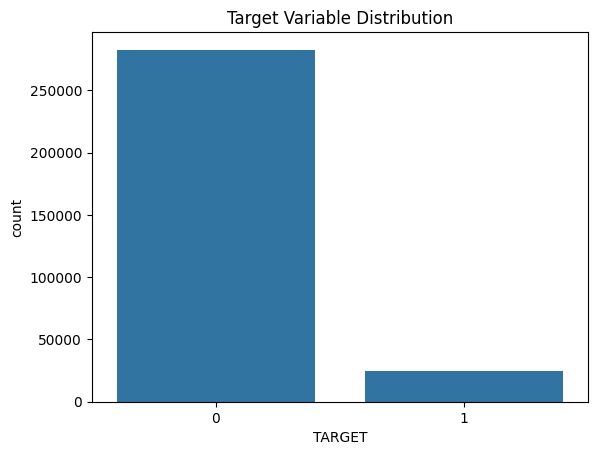

In [28]:
sns.countplot(x='TARGET', data=data)
plt.title("Target Variable Distribution")
plt.show()

**Step 3 - Data Cleaning**

In [32]:
missing_pct = df.isnull().mean().sort_values(ascending=False)
missing_pct.head(10)

,0
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
COMMONAREA_MEDI,0.698723
NONLIVINGAPARTMENTS_MEDI,0.694330
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MEDI,0.683550
LIVINGAPARTMENTS_MODE,0.683550


Observations

Some variables have >50% missing

Missingness is informative, not random

Industry insight

In credit data:

Missing values often mean:

No bureau history

No previous loans

Thin-file customers

👉 Interview line:

“In credit risk, missingness often carries risk information, so I avoid naive deletion and treat it strategically.”

In [33]:
# Seperate Target & Feature
x = df.drop(columns =['TARGET'])
y = df['TARGET']

In [34]:
# Identify Variable Types
cat_features = x.select_dtypes(include=['object']).columns
num_features = x.select_dtypes(exclude=['object']).columns

Missing Value Treatment (Industry Best Practice)
Numerical Variables

Use median imputation

Robust to outliers

Categorical Variables

Replace missing with "Missing"

In [35]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

x[num_features] = num_imputer.fit_transform(x[num_features])
x[cat_features] = cat_imputer.fit_transform(x[cat_features])

Interview line:

“I prefer simple, stable imputation techniques for regulated models to avoid adding unnecessary noise.”